In [1]:
# Ignoring warnings.
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Imports, as always...

# PyTorch (+ Geometric)
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric
from torch_geometric.nn import GCNConv

# Dimensionality reduction.
import pandas as pd
from sklearn.manifold import TSNE

# Visualisation.
import matplotlib.pyplot as plt
import seaborn as sns

# Script imports.
from scripts.training import train, evaluate
from scripts.utils import produce_reduced_embeddings, plot_reduced_embeddings
from scripts import models

In [3]:
# Beautification.
sns.set_context('paper')
sns.set_style('darkgrid')
sns.set_palette('Set2')

In [4]:
# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
# Set RNG.
torch.manual_seed(42)

In [6]:
# Dataset.
from torch_geometric.datasets import Planetoid

dataset = Planetoid(
    root='./',
    name='CiteSeer',
    split='public',
    transform=torch_geometric.transforms.GCNNorm()
  )

print(dataset.data)

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])


# (Learnable) Weighted Residual Connections

This notebook will develop a GNN with weighted residual connections, which is proposed by [Liu et al. (2024)](https://ieeexplore.ieee.org/document/10540641) to realise *sparse aggregation* (and thus alleviate semantic over-smoothing).

Formally, they  give the expression
$$
\begin{split}
H^{(l+1)}&=\mathrm{GNN}^{(l)}(\hat{A},H^{(l)})=\Xi^{(l)}\sigma(f(\hat{A},H^{(l)}))+(I_n-\Xi^{(l)})H^{(l)}\\ 
\text{with}\quad\Xi_{i,i}^{(l)}&=\Theta^{(l)}\cdot\Phi_i^{(l)}\cdot\Psi_i^{(l)}\in[0,1]\ .
\end{split}
$$

These control parameters $\Theta^{(l)}$, $\Phi_i^{(l)}$, and $\Psi_i^{(l)}$ are painstakingly computed from statistics about the graph, which includes an expensive and repetitive clustering operation. Before we go through the hassle of implementing them, I wonder whether directly learning the $\Xi_{i,i}^{(l)}$ wouldn't do the trick. This simplification of [Liu et al. (2024)](https://ieeexplore.ieee.org/document/10540641) would certainly resolve their fundamental limitation of computational expense, but it might not be direct enough to resolve the over-smoothing; we shall find out!

Instead of waiting for some given $L_0$ to start residual connections, we will arbitrarily choose to apply residual connections only between hidden layers.

In [7]:
# The proposed (learnable) weighted residual connections (L)WRC layer.
class LWRCLayer(nn.Module):
    def __init__(
        self,
        n_nodes: int,
        aggregation_function: nn.Module
    ):
        
        super(LWRCLayer, self).__init__()
        '''
        Args:
            n_nodes: number of nodes in the graph
            aggregation_function: arbitrary aggregation function of a GNN model
        '''
        
        # In accordance with the notation of Liu et al. (2024).
        self.f = aggregation_function
        self.sigma = F.relu
        
        # Aggregation weights (as a vector that will be diagonalised into a matrix in the forward).
        self.n_nodes = n_nodes
        self.w = nn.Parameter(torch.rand(n_nodes), requires_grad=True)
        self.I = nn.Parameter(torch.eye(n_nodes), requires_grad=False)
        
        
    def forward(self, X, A_hat) -> torch.Tensor:
        # Diagonalise the weights into a matrix (this is differentiable).
        # Also, pass xi through a sigmoid function to clamp the values to [0,1].
        xi = torch.diag_embed(torch.sigmoid(self.w))
        
        # Compute the two terms.
        aggregated_term = torch.matmul(xi, self.sigma(self.f(X, A_hat)))
        residual_term = torch.matmul(self.I - xi, X)
        
        # Return their sum.
        return aggregated_term + residual_term
        
    
    def generate_node_embeddings(self, X, A) -> torch.Tensor:
        return F.log_softmax(self.forward(X, A), dim=1)

In [8]:
# A GCN model (L)WRC.
class GCNWithLWRC(nn.Module):
    def __init__(
        self,
        n_nodes : int,
        input_dim : int,
        hid_dim : int,
        n_classes : int,
        n_layers : int,
        dropout_ratio : float = 0.1
    ):
        
        super(GCNWithLWRC, self).__init__()
        '''
        Args:
            input_dim: input feature dimension
            hid_dim: hidden feature dimension
            n_classes: number of target classes
            n_layers: number of layers
            dropout_ratio: dropout ratio (for training)
        '''
        
        # Parameters.
        self.n_nodes = n_nodes
        self.input_dim = input_dim
        self.hid_dim = hid_dim
        self.n_classes = n_classes
        self.n_layers = n_layers
        self.dropout_ratio = dropout_ratio
        
        # Special case for no layers.
        self.layers = nn.ModuleList([nn.Linear(input_dim, n_classes)])
            
        if n_layers and n_layers > 0:        
            # Layer dimensions.
            input_dims = [input_dim] + ([hid_dim] * (n_layers - 1))
            output_dims = ([hid_dim] * (n_layers - 1)) + [n_classes]
            
            # List of layers.
            self.layers = nn.ModuleList([
                # Only (L)WRC between hidden layers.
                LWRCLayer(n_nodes, GCNConv(x, y, add_self_loops=True, normalize=True)) if x == y else GCNConv(x, y)
                for x, y in zip(input_dims, output_dims)
            ])
        
        # Activation.
        self.act_fn = F.relu
        
        
    def forward(self, X, A) -> torch.Tensor:
        if self.n_layers and self.n_layers != 0:  
            for layer in self.layers[:-1]:
                # Update the node features (activation built in).
                X = layer(X, A)
                
                # Manual activation if necessary.
                if type(layer) != LWRCLayer:
                    X = self.act_fn(X)
                
                # Dropout during training.
                X = F.dropout(X, p=self.dropout_ratio, training=self.training)
                
            # No activation (or dropout) on the final layer.
            X = self.layers[-1](X, A)
            
        # Special case for 0-layer model.
        else: X = self.layers[0](X)
        
        return X
    
    
    def generate_node_embeddings(self, X, A) -> torch.Tensor:
        return F.log_softmax(self.forward(X, A), dim=1)

In [9]:
# Define a set of GCN models of different depths.
model_depths = [1, 5, 10, 20]
n_nodes = len(dataset.data.x)
GCNWithLWRC_models = [
    GCNWithLWRC(
        n_nodes=n_nodes,
        input_dim=dataset.num_features,
        hid_dim=64,
        n_classes=dataset.num_classes,
        n_layers=depth,
    )
    for depth in model_depths
]

# Train them.
GCNWithLWRC_models_stats = {}
for model in GCNWithLWRC_models:
    GCNWithLWRC_models_stats[model.n_layers] = train(
        model,
        dataset.data,
        device,
        progress_bar=True,
        verbose=False
    )

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

In [10]:
# Let's just have a preview of what weights were learnt.
GCNWithLWRC_models[-1].layers[2].w

Parameter containing:
tensor([0.2580, 0.7454, 0.7180,  ..., 0.2824, 0.5719, 0.8099], device='cuda:0',
       requires_grad=True)

In [11]:
# Produce the reduced embeddings over the validation nodes for each GCN model.
reduced_features_by_GCNWithLWRC_model = {
    model.n_layers : produce_reduced_embeddings(model, dataset.data, dataset.data.val_mask)
    for model in GCNWithLWRC_models
}

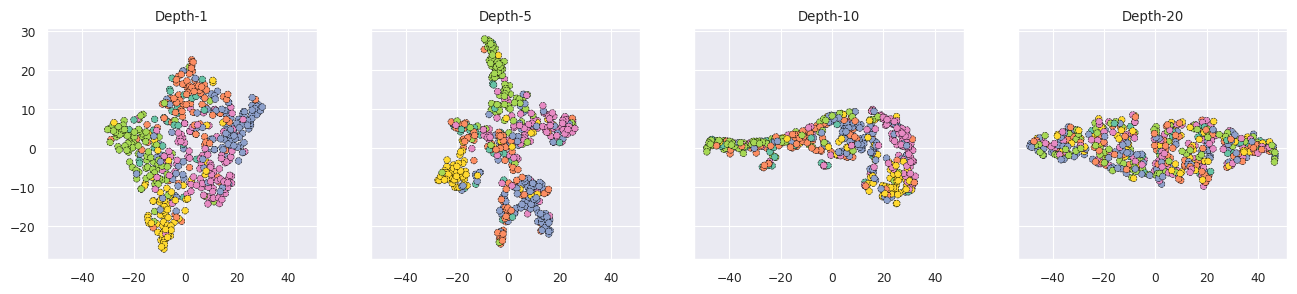

In [16]:
# Plot onto a row of axes.
fig, axes = plot_reduced_embeddings(reduced_features_by_GCNWithLWRC_model)
    
# Save figure.
plt.savefig('./figures/LWRC-GCN/convergence_by_depth.pdf', bbox_inches='tight')

# Baseline GCN

In [13]:
# Define a set of GCN models of different depths.
model_depths = [1, 5, 10, 20]
GCN_models = [
    models.GCN(
        input_dim=dataset.num_features,
        hid_dim=64,
        n_classes=dataset.num_classes,
        n_layers=depth,
    )
    for depth in model_depths
]

# Train them.
for model in GCN_models:
    train(
        model,
        dataset.data,
        device,
        progress_bar=True,
        verbose=False
    )

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/100 [00:00<?, ?it/s]

In [14]:
# Produce the reduced embeddings over the validation nodes for each GCN model.
reduced_features_by_GCN_model = {
    model.n_layers : produce_reduced_embeddings(model, dataset.data, dataset.data.val_mask)
    for model in GCN_models
}

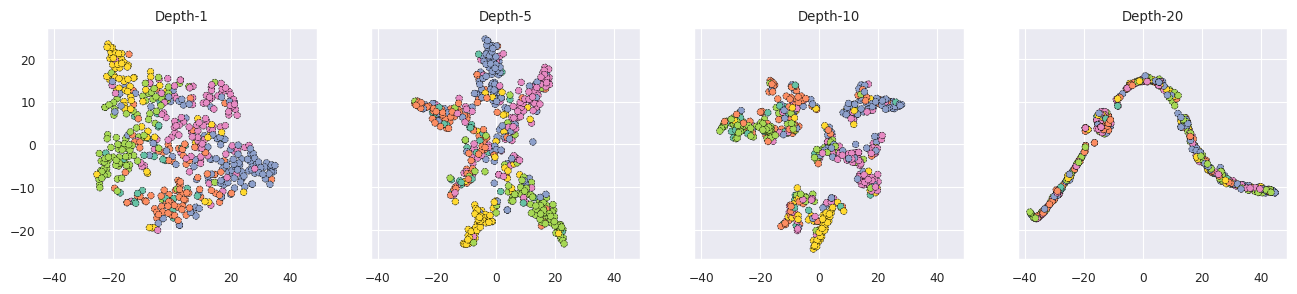

In [15]:
# Plot onto a row of axes.
fig, axes = plot_reduced_embeddings(reduced_features_by_GCN_model)
    
# Save figure.
plt.savefig('./figures/GCN/convergence_by_depth.pdf', bbox_inches='tight')

# Training Curves